In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

# створість посилання на NASA_Challenge в MyDrive або вкажіть ваш шлях до папки
DATA_PATH = "/content/drive/MyDrive/NASA_Challenge"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = f"{DATA_PATH}/data/raw/KOI_raw_2025.10.01.csv"
koi = pd.read_csv(path, comment="#", low_memory=False)
print(koi.shape)


(9564, 50)


Обираю колонки, що необхідні для навчання моделі (опціональні не обираю - буде окремий файл з ними для тестування моделі)

In [ ]:
needed_cols = [
    "kepoi_name",
    "koi_disposition",
    "koi_period",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag"
]

koi_learning = koi[needed_cols].copy()
print("Форма після відбору:", koi_learning.shape)

clean_path = f"{DATA_PATH}/data/cleaned/KOI_clean_for_learning.csv"
koi_learning.to_csv(clean_path, index=False)
print("Збережено:", clean_path)

Форма після відбору: (9564, 10)
Збережено: /content/drive/MyDrive/NASA_Challenge/data/cleaned/KOI_clean_for_learning.csv


In [ ]:
print(koi_learning.info())
print(koi_learning.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepoi_name       9564 non-null   object 
 1   koi_disposition  9564 non-null   object 
 2   koi_period       9564 non-null   float64
 3   koi_duration     9564 non-null   float64
 4   koi_depth        9201 non-null   float64
 5   koi_prad         9201 non-null   float64
 6   koi_steff        9201 non-null   float64
 7   koi_slogg        9201 non-null   float64
 8   koi_srad         9201 non-null   float64
 9   koi_kepmag       9563 non-null   float64
dtypes: float64(8), object(2)
memory usage: 747.3+ KB
None
          koi_period  koi_duration     koi_depth       koi_prad     koi_steff  \
count    9564.000000   9564.000000  9.201000e+03    9201.000000   9201.000000   
mean       75.671358      5.621606  2.379134e+04     102.891778   5706.823280   
std      1334.744046      6.471554  8.2

Подивимось на екстримальні занчення

<Figure size 1200x600 with 0 Axes>

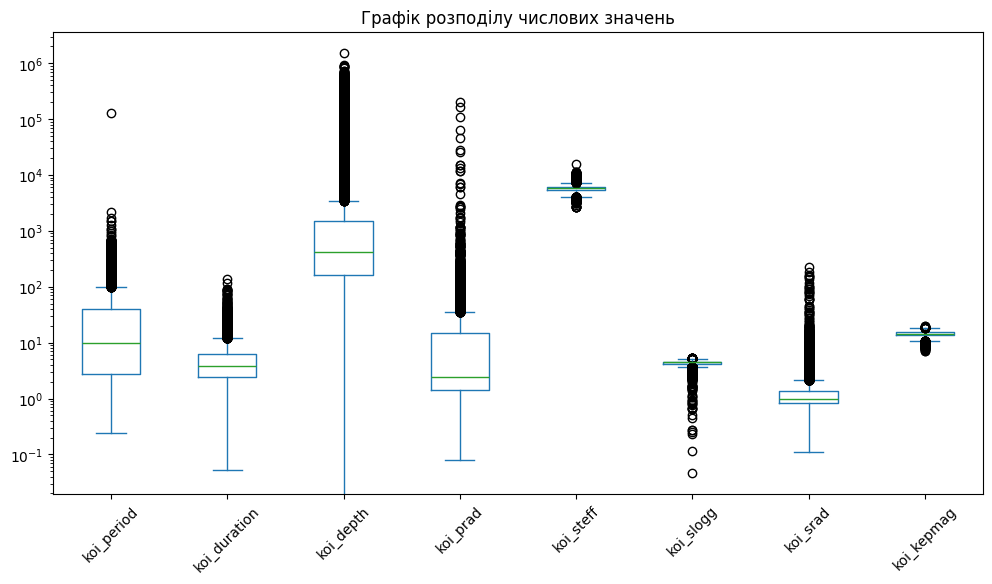

In [ ]:
num_cols = ["koi_period","koi_duration","koi_depth","koi_prad",
            "koi_steff","koi_slogg","koi_srad","koi_kepmag"]

plt.figure(figsize=(12,6))
koi_learning[num_cols].plot(kind="box", subplots=False, logy=True, figsize=(12,6))
plt.title("Графік розподілу числових значень")
plt.xticks(rotation=45)
plt.show()


Аналіз null значень:

In [ ]:
# кількість пропусків у кожній колонці
missing = koi_learning.isna().sum()
missing_percent = (missing / len(koi_learning)) * 100

missing_table = pd.DataFrame({
    "Missing Values": missing,
    "Percent (%)": missing_percent
}).sort_values(by="Percent (%)", ascending=False)

print(missing_table)


                 Missing Values  Percent (%)
koi_depth                   363     3.795483
koi_prad                    363     3.795483
koi_srad                    363     3.795483
koi_steff                   363     3.795483
koi_slogg                   363     3.795483
koi_kepmag                    1     0.010456
koi_disposition               0     0.000000
kepoi_name                    0     0.000000
koi_period                    0     0.000000
koi_duration                  0     0.000000


*1. koi_kepmag - 1 null*

Це не суттєво, тому видаляю рядок

*2. koi_depth, koi_prad, koi_srad, koi_steff, koi_slogg - по 363 null*

Оскільки за графіком розподілу значень koi_slogg,  koi_prad мають ярковиражені екстримальні значення, то доречно замінювати відсутні знаяення модою. Для інших колонок підійде і середнє значення, але воно не сильно відрізняєтся від моди, тому для простоти:

Відсутні значення замінюю на моду + додаю стовпці-прапорці з інформацією про відсутність відповідних даних

In [ ]:
koi_learning = koi_learning.dropna(subset=["koi_kepmag"])

cols = ["koi_depth", "koi_prad", "koi_srad", "koi_steff", "koi_slogg"]

for col in cols:
    koi_learning[f"{col}_missing"] = koi_learning[col].isna().astype(int)
    koi_learning[col] = koi_learning[col].fillna(koi_learning[col].mode()[0])

koi_learning
koi_learning.to_csv(f"{DATA_PATH}/data/cleaned/KOI_clean_for_learning.csv", index=False)


Логарифмічне перетворення лише для колонок, де розподіл має сильні «хвости» та екстремальні значення:

koi_period, koi_depth, koi_prad, koi_srad.

Використано np.log1p(x) (тобто log(1+x)), щоб безпечно обробляти значення, включаючи дуже малі або 0.

Це зменшує вплив викидів і робить розподіл більш «стабільним» для моделі.

Інші параметри (duration, teff, slogg, kepmag) залишені як є, бо вони не мають критичних викидів.

In [ ]:
log_cols = ["koi_period", "koi_depth", "koi_prad", "koi_srad"]

for col in log_cols:
    koi_learning[f"{col}_log"] = np.log1p(koi_learning[col])  # log(1+x), щоб уникнути log(0)
koi_learning.to_csv(f"{DATA_PATH}/data/cleaned/KOI_clean_for_learning.csv", index=False)

<Figure size 1200x600 with 0 Axes>

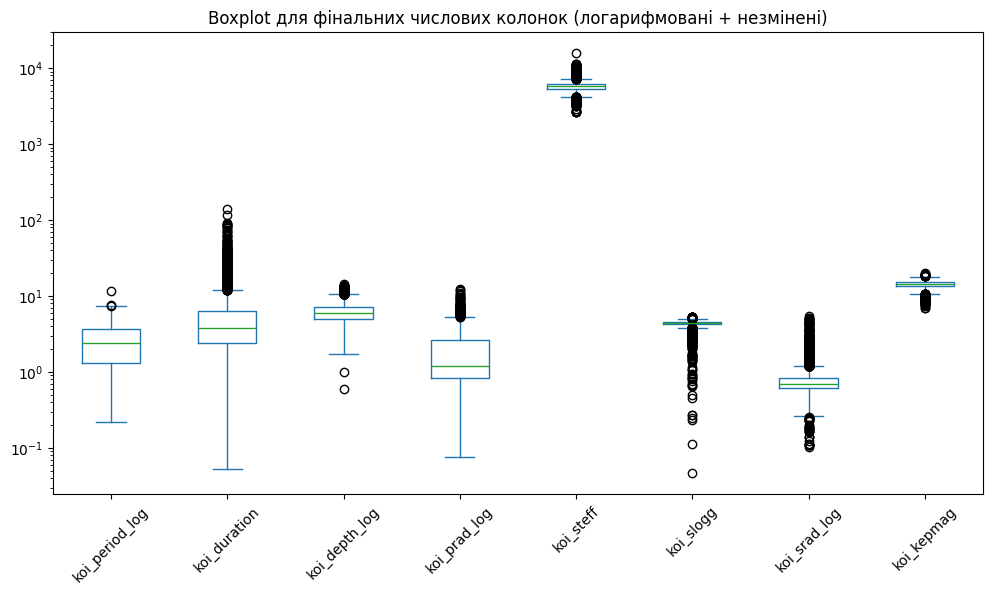

In [ ]:
final_cols = ["koi_period_log", "koi_duration", "koi_depth_log", "koi_prad_log", "koi_steff",
              "koi_slogg", "koi_srad_log", "koi_kepmag"]

plt.figure(figsize=(12,6))
koi_learning[final_cols].plot(kind="box", logy=True, figsize=(12,6))
plt.title("Boxplot для фінальних числових колонок (логарифмовані + незмінені)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
koi_learning.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9563 entries, 0 to 9563
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         9563 non-null   object 
 1   koi_disposition    9563 non-null   object 
 2   koi_period         9563 non-null   float64
 3   koi_duration       9563 non-null   float64
 4   koi_depth          9563 non-null   float64
 5   koi_prad           9563 non-null   float64
 6   koi_steff          9563 non-null   float64
 7   koi_slogg          9563 non-null   float64
 8   koi_srad           9563 non-null   float64
 9   koi_kepmag         9563 non-null   float64
 10  koi_depth_missing  9563 non-null   int64  
 11  koi_prad_missing   9563 non-null   int64  
 12  koi_srad_missing   9563 non-null   int64  
 13  koi_steff_missing  9563 non-null   int64  
 14  koi_slogg_missing  9563 non-null   int64  
 15  koi_period_log     9563 non-null   float64
 16  koi_depth_log      9563 non-n

In [ ]:
koi_learning.to_csv(f"{DATA_PATH}/data/cleaned/KOI_clean_for_learning.csv", index=False)